# 1D Edge Analysis
This notebook performs edge detection on an image and analyzes the result by averaging along one axis to create 1D profiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
plt.style.use('default')
%matplotlib widget

Image shape: (1080, 1920)
Image data type: float32
Image value range: 0.0 to 255.0


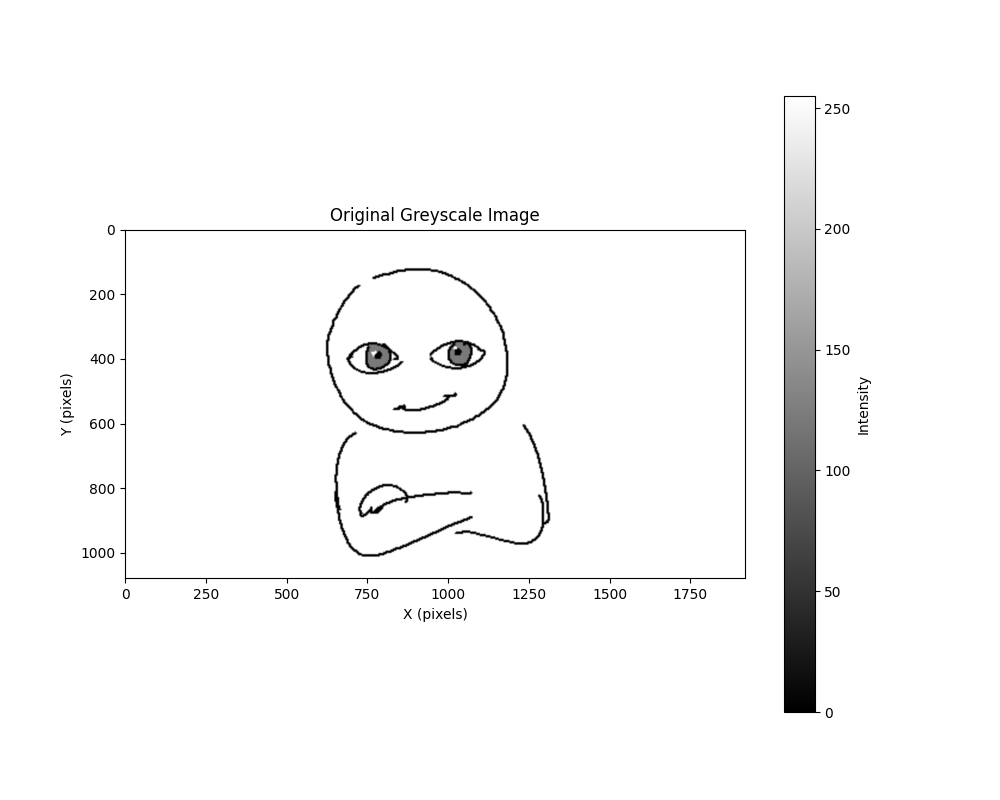

In [2]:
# Load and convert image to greyscale
def load_image(image_path):
    """
    Load an image from file path
    """
    img = Image.open(image_path)
    return img

def convert_to_greyscale(img):
    """
    Convert an image to greyscale and return as numpy array
    """
    # Convert to greyscale
    img_grey = img.convert('L')
    
    # Convert to numpy array
    img_array = np.array(img_grey, dtype=np.float32)
    
    return img_array

# Load the mario image
image_path = 'blueeyes.jpg'
img_color = load_image(image_path)
img_grey = convert_to_greyscale(img_color)

print(f"Image shape: {img_grey.shape}")
print(f"Image data type: {img_grey.dtype}")
print(f"Image value range: {img_grey.min()} to {img_grey.max()}")

# Display the original greyscale image
plt.figure(figsize=(10, 8))
plt.imshow(img_grey, cmap='gray', aspect='equal')
plt.title('Original Greyscale Image')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.colorbar(label='Intensity')
plt.show()

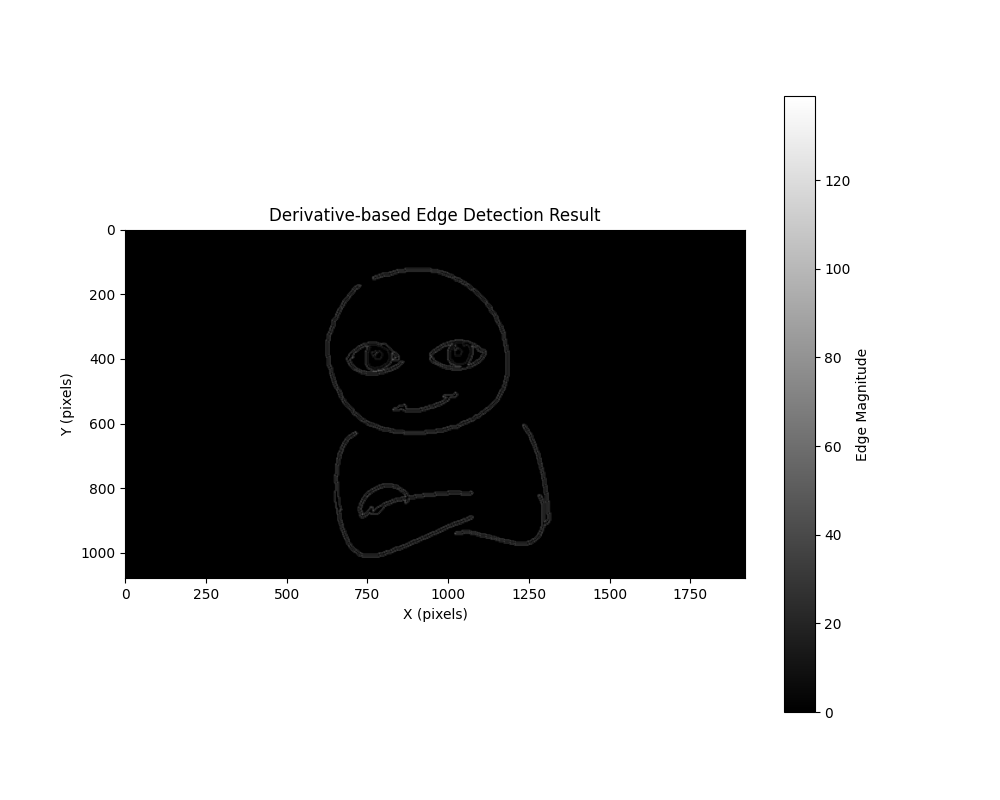

Edge image shape: (1080, 1920)
Edge pixels detected: 73813 out of 2073600 total pixels
Edge magnitude range: 0.0 to 139.0


In [3]:
# Perform derivative-based edge detection
def apply_derivative_edge_detection(image):
    """
    Apply derivative-based edge detection by taking differences between adjacent pixels
    """
    dx = apply_derivative_edge_detection_along_axis(image, 1)

    dy = apply_derivative_edge_detection_along_axis(image, 0)
    
    # Combine derivatives - use magnitude of gradient
    gradient_magnitude = np.sqrt(dx**2 + dy**2)
    
    return gradient_magnitude

def apply_derivative_edge_detection_along_axis(image, axis=0):
    """
    Apply derivative-based edge detection by taking differences between adjacent pixels
    """
    # Calculate derivatives in axis direction
    dx = np.zeros_like(image, dtype=np.float32)
    if axis == 1:
        dx[:, 2:] = np.diff(np.diff(image, axis=axis), axis=axis)
    else:
        dx[2:, :] = np.diff(np.diff(image, axis=axis), axis=axis)
    
    return dx

# Apply derivative-based edge detection
img_edges = apply_derivative_edge_detection(img_grey)

# Display the edge-detected image
plt.figure(figsize=(10, 8))
plt.imshow(img_edges, cmap='gray', aspect='equal')
plt.title('Derivative-based Edge Detection Result')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.colorbar(label='Edge Magnitude')
plt.show()

print(f"Edge image shape: {img_edges.shape}")
print(f"Edge pixels detected: {np.sum(img_edges > 0)} out of {img_edges.size} total pixels")
print(f"Edge magnitude range: {img_edges.min()} to {img_edges.max()}")

In [4]:
# Average edge-detected image along different axes to create 1D profiles
def create_1d_profile(edge_image, axis=0):
    """
    Create 1D profiles by averaging the edge image along different axes
    """
    height, width = edge_image.shape
    
    # Average along Y-axis (vertical) to get horizontal profile
    profile = np.mean(edge_image, axis=axis)  # Average each column
    if axis == 0:
        positions = np.arange(edge_image.shape[1])
    else:
        positions = np.arange(edge_image.shape[0])
        
    
    return profile, positions

# Create 1D profiles
img_edges_h = apply_derivative_edge_detection_along_axis(img_grey, axis=1)
h_profile, x_pos = create_1d_profile(img_edges_h, axis=0)

img_edges_v = apply_derivative_edge_detection_along_axis(img_grey, axis=0)
v_profile, y_pos = create_1d_profile(img_edges_v, axis=1)

print(f"Horizontal profile shape: {h_profile.shape}")
print(f"Vertical profile shape: {v_profile.shape}")
print(f"Horizontal profile range: {h_profile.min():.2f} to {h_profile.max():.2f}")
print(f"Vertical profile range: {v_profile.min():.2f} to {v_profile.max():.2f}")

Horizontal profile shape: (1920,)
Vertical profile shape: (1080,)
Horizontal profile range: -4.73 to 3.99
Vertical profile range: -2.03 to 3.33


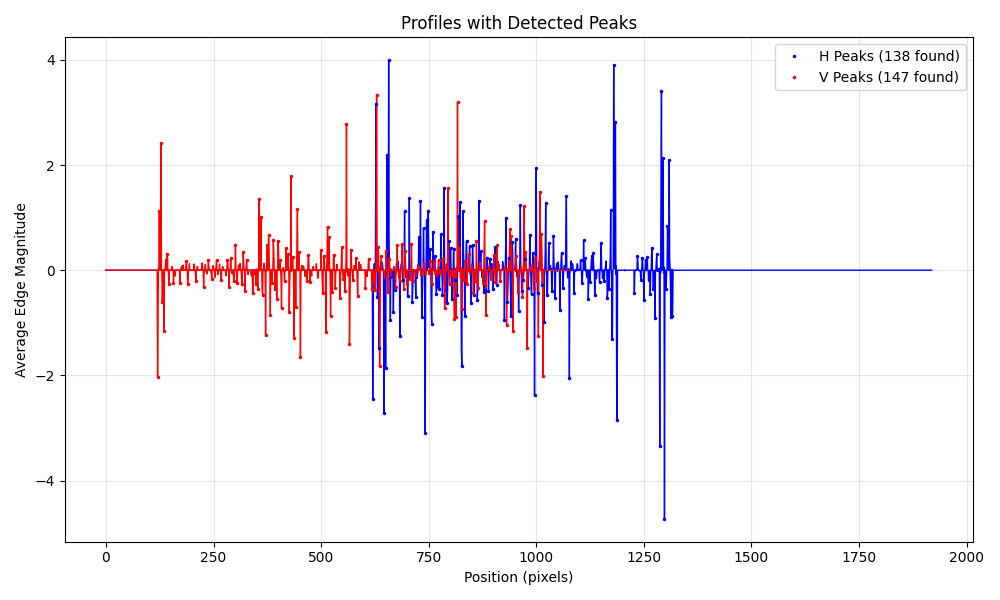

In [5]:
# Analysis of 1D profiles - find peaks and patterns
def find_profile_peaks(profile, positions):
    from scipy.signal import find_peaks
    
    # Find peaks in the profile
    # Use a threshold based on mean + standard deviation
    threshold = 0.5 * np.std(profile)
    peaks_high, properties_high = find_peaks(profile, height=threshold, distance=1)
    peaks_low, properties_low = find_peaks(profile * -1.0, height=threshold, distance=1)

    peaks = np.concatenate([peaks_high, peaks_low])

    return peaks

# Analyze both profiles for periodic patterns
h_peaks = find_profile_peaks(h_profile, x_pos)
v_peaks = find_profile_peaks(v_profile, y_pos)

    # Plot profile with peaks marked
plt.figure(figsize=(10, 6))
plt.plot(x_pos, h_profile, 'b-', linewidth=1)
plt.plot(y_pos, v_profile, 'r-', linewidth=1)
plt.plot(x_pos[h_peaks], h_profile[h_peaks], 'b.', markersize=3, label=f'H Peaks ({len(h_peaks)} found)')
plt.plot(y_pos[v_peaks], v_profile[v_peaks], 'r.', markersize=3, label=f'V Peaks ({len(v_peaks)} found)')
plt.xlabel('Position (pixels)')
plt.ylabel('Average Edge Magnitude')
plt.title(f'Profiles with Detected Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

3.680628906249964 1.0867358988618427
3.6859521484374644 0.9191578522391886


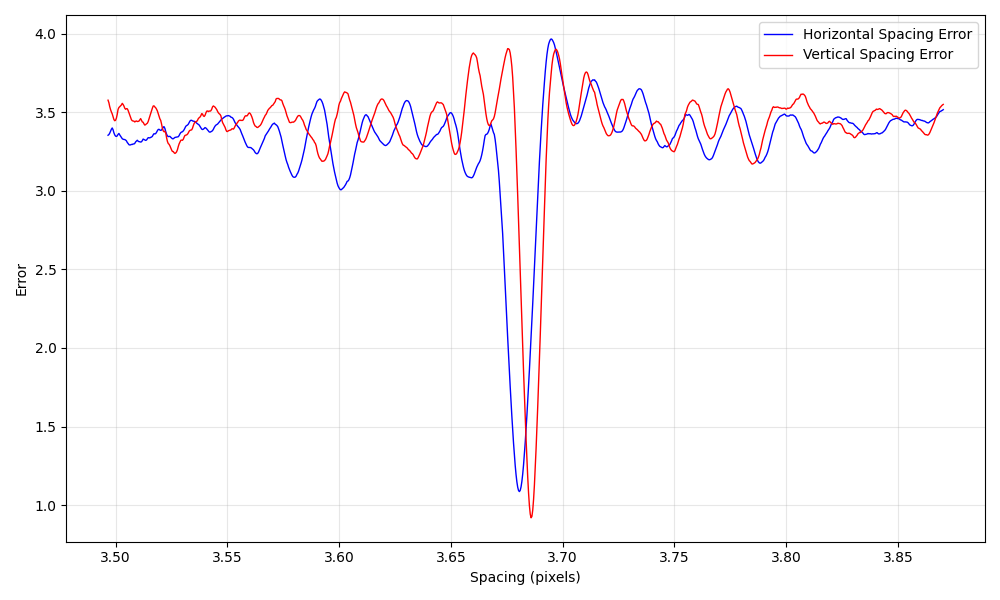

In [6]:
def get_peaks_error(peak_positions, spacing):
    total_error = 0
    offset = peak_positions[0]

    ks = []
    for peak in peak_positions:
        # Find best integer assignment for this peak
        k = round((peak - offset) / spacing)
        ks.append(k)
        predicted_position = offset + k * spacing
        error = (peak - predicted_position) ** 2
        total_error += error

    total_error  = np.sqrt(total_error)
    # Reward larger spacings
    total_error /= spacing
        
    return total_error

def find_minimum_coarse(peaks):
    from scipy.signal import find_peaks

    spacings = np.arange(2.0, 10.0, 0.01)
    spacing_errors = [get_peaks_error(h_peaks, s) for s in spacings]
    spacing_errors = np.array(spacing_errors) * -1.0
    
    threshold = np.mean(spacing_errors) + 5.0 * np.std(spacing_errors)
    peaks, properties = find_peaks(spacing_errors, height=threshold, distance=1)

    peak_spacings = spacings[peaks]
    return peak_spacings

def find_minimum_fine(peaks, initial_guess):
    from scipy.optimize import minimize
    
    def objective(params):
        spacing = params[0]
        return get_peaks_error(peaks, spacing)
    
    # Optimize
    result = minimize(objective, [initial_guess], 
                     method='Nelder-Mead')
    
    optimal_spacing, = result.x
    return optimal_spacing

def find_optimal_spacing(peaks):
    error_peaks = find_minimum_coarse(peaks)
    candidate_spacings = [find_minimum_fine(peaks, p) for p in error_peaks]
    candidate_errors = [get_peaks_error(peaks, spacing) for spacing in candidate_spacings]
    optimal_spacing = candidate_spacings[np.argmin(candidate_errors)]
    optimal_spacing_error = candidate_errors[np.argmin(candidate_errors)]
    return optimal_spacing, optimal_spacing_error

optimal_spacing_h, optimal_spacing_error_h = find_optimal_spacing(h_peaks)
optimal_spacing_v, optimal_spacing_error_v = find_optimal_spacing(v_peaks)

print(optimal_spacing_h, optimal_spacing_error_h)
print(optimal_spacing_v, optimal_spacing_error_v)

spacings = np.linspace(np.min([optimal_spacing_h, optimal_spacing_v]) * 0.95, np.max([optimal_spacing_h, optimal_spacing_v]) * 1.05, 1000)
spacing_errors_h = [get_peaks_error(h_peaks, s) for s in spacings]
spacing_errors_v = [get_peaks_error(v_peaks, s) for s in spacings]

plt.figure(figsize=(10, 6))
plt.plot(spacings, spacing_errors_h, 'b-', linewidth=1, label='Horizontal Spacing Error')
plt.plot(spacings, spacing_errors_v, 'r-', linewidth=1, label='Vertical Spacing Error')
plt.legend()
plt.xlabel('Spacing (pixels)')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# optimal_spacing, optimal_offset, assignments = find_grid_least_squares(v_peaks)
# error = get_peaks_error(v_peaks, optimal_spacing, optimal_offset)
# print(optimal_spacing, optimal_offset, error)

In [7]:
def get_offset_as_phase(offset, spacing):
    return np.mod((offset / spacing) * 2.0 * np.pi, 2.0*np.pi) - np.pi
print(get_offset_as_phase(h_peaks[0], optimal_spacing_h))
print(get_offset_as_phase(v_peaks[0], optimal_spacing_v))

0.7729241960097433
0.8874356368607685


In [8]:
def get_pixel_borders(spacing, offset):
    return np.arange(offset, offset+len(h_profile), spacing) - offset
    
def plot_pixel_grid(profile, positions, spacing, offset):
    pixel_borders = get_pixel_borders(spacing, offset)
    
    plt.figure(figsize=(12, 6))
    plt.plot(positions, profile, 'b-', linewidth=1)
    for pixel_border in pixel_borders:
        plt.axvline(pixel_border, color='red', linestyle='-', alpha=0.7, linewidth=1)
    plt.xlabel('Position (pixels)')
    plt.ylabel('Average Edge Magnitude')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

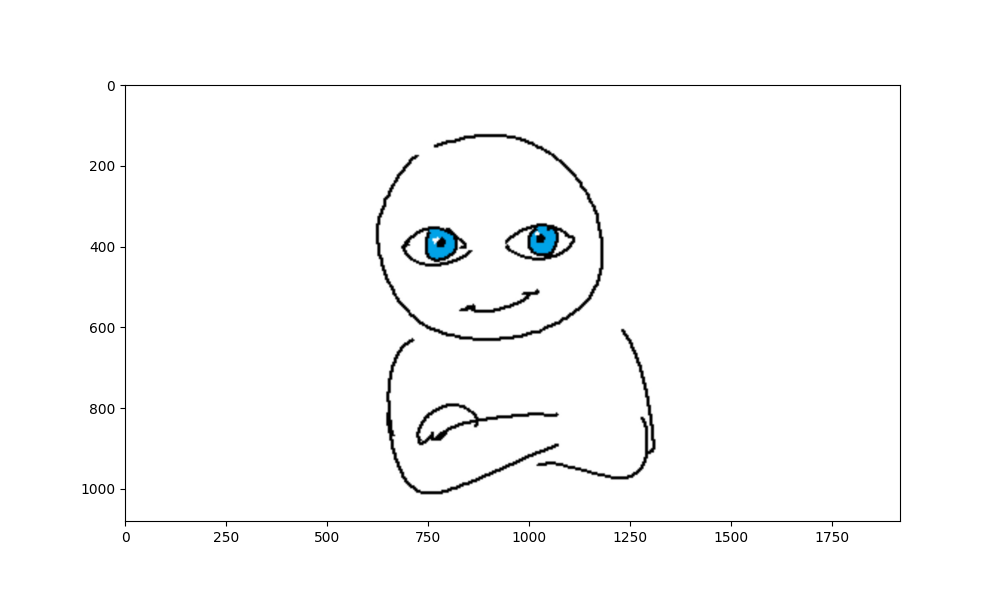

In [20]:
def rescale_image(image, pixel_spacing_h, pixel_spacing_v, new_spacing):
    from scipy.ndimage import zoom
    
    h_scale = new_spacing / pixel_spacing_h
    v_scale = new_spacing / pixel_spacing_v

    return image.resize((int(image.size[0]*h_scale), int(image.size[1]*v_scale)))

img_scaled = rescale_image(img_color, optimal_spacing_h, optimal_spacing_v, 1.0)

plt.figure(figsize=(10, 6))
plt.imshow(img_color)
plt.show()

img_scaled.save("image_scaled.png")